### Full Multi Grid Solution of the Two Dimensional Dilaton Field Equation 
##### Vikram Vyas

#### About this notebook
This notebook was used to do the numerical calculations described in the section 4.4 of the accompanying paper "Flux-tubes and their intrinsic shape in confining gauge theories with gravitational dual" Please feel free to use it for any accademic purpose. For any comments or clarification send me an email: vikram@physicsinfield.org
#### How to use this notebook

The notebook requires the python files:

utility_2DimMG.py

#### References

For multigrid algorithm used see:

J. Stewart. Python for Scientists. Cambridge University Press, 2017.

and the python implementation

https://github.com/AbhilashReddyM/GeometricMultigrid


#### Acknowledgments
I would like to thank the world wide community of python developers.


#### Python preliminaries

In [1]:
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

# for using Cython
%load_ext Cython

#### Utility functions for Multigrid

In [2]:
from utility_2DimMG import L2_norm, prolong_lin, restric, restrict_hw

#### Cythonized code for relaxation and residue calculation for the two dimensional dilaton field equation

In [3]:
%%cython
cimport numpy as np
cimport cython
@cython.boundscheck(False) # turn of bounds-checking for entire function
@cython.wraparound(False)
@cython.cdivision(True)

cdef A(float a, float nz):
    return (1.0/( a * nz))**3


cdef B(float sigma, float a, float nz):
    return sigma**2 * ((1.0 /(a * nz))**3 - a * nz)


cdef C(float sigma, float a, float nz):
    return 2*A(a, nz+0.5)+B(sigma, a, nz-0.5)+B(sigma, a, nz+0.5)


# solving L(error) = errorCentre - errorB - errorZ = source
def updateError(float sigma, int Nz, int Nx1,  
                np.ndarray[np.float_t, ndim = 2, negative_indices = False,  mode = 'c'] phi,  
                np.ndarray[np.float_t, ndim = 2, negative_indices = False,  mode = 'c'] source):
    
        cdef int nz, nx1
        cdef float a, D, deltaPhiB, deltaPhiZ, newPhi
        
        # lattice constant in the units of z_0
        a = 1.0/(Nz-1)
        
        for nz in range(1, Nz - 1):
            for nx1 in range(1, Nx1 - 1):
                if nz == Nz-2:
                    phi[Nz - 1, nx1] = phi[Nz - 2, nx1] # Neumann B.C. at z = Nz
                deltaPhiB = A(a, nz + 0.5) * (phi[nz, nx1+1]+phi[nz, nx1-1])
                deltaPhiZ = B(sigma, a, nz + 0.5) * phi[nz+1, nx1] + B(sigma, a, nz-0.5)*phi[nz-1, nx1]
                newPhi = (1.0/C(sigma, a, nz)) * (deltaPhiB + deltaPhiZ + source[nz, nx1])
                phi[nz, nx1] = newPhi

def relaxError(float sigma, int Nz, int Nx1,  
               np.ndarray[np.float_t, ndim = 2, negative_indices = False,  mode = 'c'] phi,  
               np.ndarray[np.float_t, ndim = 2, negative_indices = False,  mode = 'c'] source, int nit = 1):
    cdef int ii
    for ii in range(nit):
        updateError(sigma, Nz, Nx1, phi, source)
    return phi

def residue(float sigma, int Nz, int Nx1,
            np.ndarray[np.float_t, ndim = 2, negative_indices = False,  mode = 'c'] phi,
            np.ndarray[np.float_t, ndim = 2, negative_indices = False,  mode = 'c'] jSource, 
            np.ndarray[np.float_t, ndim = 2, negative_indices = False,  mode = 'c'] residue):
    
    # L(phi) = phiCentre - phiB - phiZ = jSource
    # res = jSource - L(phi)
 
    # lattice constant in the units of z_0 = 1
    a = 1.0/(Nz - 1.0)
    
    #residue = np.zeros((Nz, Nx1, Nx2), float)
    for nz in range(1, Nz - 1):
        for nx1 in range(1, Nx1 - 1):
            if nz == Nz-2:
                    phi[Nz - 1, nx1] = phi[Nz - 2, nx1] # Neumann B.C. at z = Nz
            phiCentre = C(sigma, a, nz) * phi[nz, nx1]
            phiB = A(a, nz + 0.5) * (phi[nz, nx1+1]+phi[nz, nx1-1])
            phiZ = B(sigma, a, nz + 0.5) * phi[nz+1, nx1] + B(sigma, a, nz-0.5)*phi[nz-1, nx1]
            residue[nz, nx1] = jSource[nz, nx1] + (phiB + phiZ - phiCentre)
    return residue

In [4]:
def V_cycle(sigma, nz, nx1, num_levels, phi, source, level=1):
    
    # solve exactly at the bottom layer - recursion ends here
    if (level==num_levels):
        phi = relaxError(sigma, nz, nx1, phi, source, nit=100)
        return phi
    
    #Step 1: Relax L(phi) = source on this grid and calculate the residue
    phi = relaxError(sigma, nz, nx1, phi, source, nit=75)
    res = np.zeros_like(phi)
    res = residue(sigma, nz, nx1, phi, source, res)
    
    
    #Step 2: Restrict residual to coarse grid
    res_c = restrict_hw(res)
    
    #Step 3:Solve Le_c=res_c on the coarse grids recursively
    coarseGridShape = np.shape(res_c)
    NzC, Nx1C = coarseGridShape[0], coarseGridShape[1]
    err_c = np.zeros_like(res_c)
    err_c = V_cycle(sigma, NzC, Nx1C, num_levels, err_c, res_c, level+1)
    
    
    #Step 4: Interpolate(prolong) e_c to fine grid and add to phi
    phi = phi + prolong_lin(err_c)
    
    #Step 5: Relax L(phi) = source on this grid 
    phi = relaxError(sigma, nz, nx1, phi, source, nit=75)
    
    return phi

In [5]:
def FMG(sigma, nz, nx1, num_levels, source, nv=1, level=1):
    # solve exactly at the bottom layer 
    
    if (level==num_levels):
        phi = np.zeros_like(source)
        phi = relaxError(sigma, nz, nx1, phi, source, nit=100)
        print("solved the bottom grid")
        return phi
    
    #Step 1: Restrict the rhs to a coarse grid
    source_c = restrict_hw(source)
    
    #Step 2: Solve the coarse grid problem using FMG
    coarseGridShape = np.shape(source_c)
    NzC, Nx1C = coarseGridShape[0], coarseGridShape[1]
    current_level = level + 1
    phi_c = FMG(sigma, NzC, Nx1C, num_levels, source_c, nv, current_level)
    
    #Step 3: Interpolate phi_c to the fine grid
    phi = prolong_lin(phi_c)
    
    
    #step 4: Execute 'nv' V-cycles
    for _ in range(nv):
        phi = V_cycle(sigma, nz, nx1, num_levels-level, phi, source)
    print("finished V-cycles for level = ", num_levels-level)
    return phi

### Geometry of the fine lattice
Length along the radial direction in the units of lattice constants $a$. Lattice constant along $X_T$ is $b =\sigma a$

In [6]:
num_levels = 8
Lz = LxT  = 2**(num_levels + 1)
a = 1.0/Lz
sigma = 5.0
b = a * sigma
print("L = ", Lz, "a = ", a ,"b = sigma * a = ",  b)

L =  512 a =  0.001953125 b = sigma * b =  0.009765625


For each direction, the number of points is one more than the length

In [7]:
Nz = Lz + 1
NxT = LxT + 1
print(Lz, Nz)

512 513


### Dilaton field
Initially set to zero. This also implements the homogenous Dirichlet on all boundaries
 we will implement Neumann BC on $z = L_z$ plane in the relaxation algorithm.

In [8]:
Phi = np.zeros((Nz,NxT), float)                                    

### Source function for a very long open string

An infinitely long open string at $z=z_0$, with  along $x_L$ is holographically dual to a very long flux-tube connecting a quark and an anti-quark placed along $x_L$ in the limit when the distance between the quark and the anti-quark, L, goes to infinity. This open string acts as a source for the dilaton field:

$$S(z, x_T) =  \sigma * \frac{g}{z_m^2}\delta(x_T, LxT/2)\delta(z,z_m) $$ where 
$$g = \frac{\lambda^1/2}{8\pi}$$ and $z_m\rightarrow z_0$.

In [9]:
g = -10 # negative sign is to incorporate L(phi) = - stringSource
NzM =  Nz - 2 # we are putting the string just below the boundary at z=z_0 
zM = NzM * a 
sourceArray = np.zeros((Nz, NxT), float)
sourceArray[NzM,int(NxT/2.0)] = sigma * g/(zM ** 2)# top middle

### Solving using FMG

In [10]:
%%time
Phi = FMG(sigma, Nz, NxT, num_levels, sourceArray, nv = 125, level = 1 )

solved the bottom grid
finished V-cycles for level =  1
finished V-cycles for level =  2
finished V-cycles for level =  3
finished V-cycles for level =  4
finished V-cycles for level =  5
finished V-cycles for level =  6
finished V-cycles for level =  7
CPU times: user 37min 31s, sys: 5.08 s, total: 37min 36s
Wall time: 37min 28s


In [11]:
res = np.zeros_like(Phi)
res = residue(sigma, Nz, NxT, Phi, sourceArray, res)
resL2Norm = L2_norm(res, a)
print("Final residue = ", resL2Norm)

Final residue =  4.997357686583155e-06


#### Plotting the Dilaton field produced by an infinitely long string

#### Setting the colour scheme

In [12]:
colorinterpolation = 50
colourMap = plt.cm.jet #you can try: colourMap = plt.cm.coolwarm

#### Setting the mesh grid

In [13]:
X, Z = np.meshgrid(np.arange(0, NxT), np.arange(0, Nz))

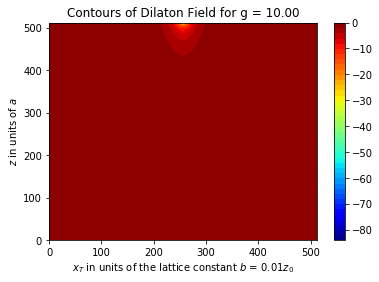

In [14]:
# Configure the contour
contoursTitle = "Contours of Dilaton Field for g = %4.2f" % (abs(g))
plt.title(contoursTitle)
plt.contourf(X, Z, Phi, colorinterpolation, cmap=colourMap)

# Set Colorbar
plt.colorbar()

# Set the axis
xlabel = "$x_T$ in units of the lattice constant $b$ = %4.2f$z_0$" % (b)
plt.xlabel(xlabel)
ylabel = "$z$ in units of $a$ = %4.3f$z_0$" % (a)
plt.ylabel(ylabel)
# Show the result in the plot window
contourFig = "Contours of Dilaton Field for g = %4.2f" % (abs(g))
plt.savefig("Contours of Dilaton Field.pdf"+str(Nz)+str(NzM))
plt.show()


### Calculating $z_0^4<\Omega|{\widehat{\mathcal{O}}_{F^{2}}}\left(nx; a\right)|\Omega>_{q\bar{q}}$

In [15]:
def B(a, nz):
    return (1.0 /(a * nz))**3 - a * nz

Ez = - (B(a,0.5)/a) * Phi[1, :]
EzMaxM = Ez.max()
print(EzMaxM)

7.449185371392151


#### Half width of the the flux-tube

In [16]:
xrange = np.arange(NxT)
centre = np.sum(xrange * Ez)/np.sum(Ez)
width = np.sqrt(np.abs(np.sum((xrange-centre)**2*Ez)/np.sum(Ez)))
widthLabel = "Half Width = %4.2f $z_0$" % (width*b)
print(widthLabel)

Half Width = 0.57 $z_0$


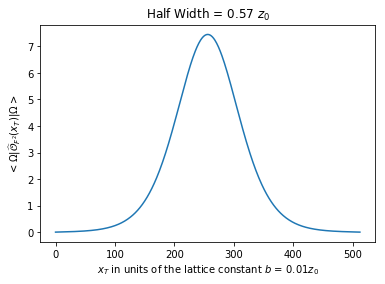

In [17]:
xrange = np.arange(NxT)
widthLabel = "Half Width = %4.2f $z_0$" % (width*b)
plt.title(widthLabel)
xlabel = "$x_T$ in units of the lattice constant $b$ = %4.2f$z_0$" % (b)
plt.xlabel(xlabel)
plt.ylabel("$<\Omega|{\widehat{\mathcal{O}}_{F^{2}}(x_T)}|\Omega>$")
plt.plot(xrange, Ez)
#plt.savefig("Shape of the flux-tube.pdf")
plt.show()

### Fitting to a Gaussian

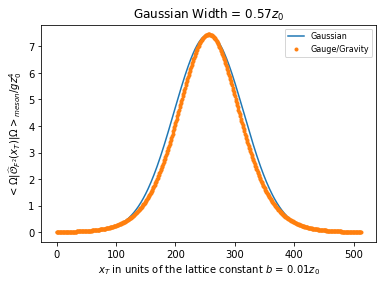

In [18]:
centre = np.sum(xrange * Ez)/np.sum(Ez)
width = np.sqrt(np.abs(np.sum((xrange-centre)**2*Ez)/np.sum(Ez)))
widthLabel = "Gaussian Width = %4.2f$z_0$" % (width*b)

peak = Ez.max()
gaussianFit = lambda t: peak * np.exp(-(t-centre)**2/(2*width**2))
plt.plot(gaussianFit(xrange), '-',label='Gaussian')
plt.plot(xrange, Ez,'.', label = 'Gauge/Gravity')
plt.legend(fontsize = 8)
plt.title(widthLabel)
xlabel = "$x_T$ in units of the lattice constant $b$ = %4.2f$z_0$" % (b)
plt.xlabel(xlabel)
plt.ylabel("$<\Omega|{\widehat{\mathcal{O}}_{F^{2}}(x_T)}|\Omega>_{meson}/{gz_0^4}$")
plt.show()

### Fitting to an exponential
We will fit 
$$P_{T}\left(x_{T}\right)=C_{0}\exp\left(-\frac{|x_{T}|}{\xi_{FT}}\right)$$

In [19]:
from scipy.optimize import curve_fit

[4.1264447  0.02633177]


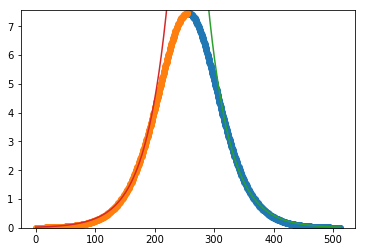

In [20]:
def myFit(x2, maxE, Mglue):
    return maxE * np.exp(-Mglue * x2)

# data for curve fitting
startAt = int(centre + width)
endAt = startAt + 100

xTrial = xrange[startAt:endAt] - startAt
EzTrial = Ez[startAt:endAt]

# trial parameters for the fit function
maxTrial = 1.0
glueMassTrial = 1.0 

trialParmeters = (maxTrial, glueMassTrial)

# Fitting the data
optParam, pcov = curve_fit(myFit, xTrial, EzTrial, trialParmeters)
maxE, Mglue = optParam

print(optParam)

# Plotting the fit function
xRight = xrange[int(centre):]
EzRight = Ez[int(centre):]

xLeft = xrange[:int(centre)]
EzLeft = Ez[:int(centre)]

EzFitExp = myFit(xRight - startAt, maxE, Mglue)
endLeft = int(centre - width)
startLeft = endLeft - 100
EzFitLeft = myFit(endLeft - xLeft, maxE, Mglue)
plt.ylim([0, Ez.max() + 0.1])
plt.plot(xRight, EzRight, 'o')
plt.plot(xLeft, EzLeft, 'o')
plt.plot(xRight, EzFitExp)
plt.plot(xLeft,EzFitLeft)
plt.show()

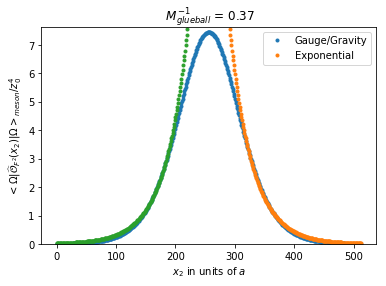

In [22]:
titleLable = " $M^{-1}_{glueball}$ = %4.2f" % (1/ Mglue * b )
plt.ylim([0, Ez.max() + 0.2])
plt.xlabel("$x_2$ in units of $a$")
plt.ylabel("$<\Omega|{\widehat{\mathcal{O}}_{F^{2}}(x_2)}|\Omega>_{meson}/{z_0^4}$")

plt.plot(xrange, Ez, '.', label = 'Gauge/Gravity')
plt.plot(xRight, EzFitExp, '.', label = 'Exponential')
plt.plot(xLeft, EzFitLeft, '.')
plt.legend()
plt.title(titleLable)

plt.show()